In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from astropy.table import Table, vstack, Column
import os
import pdb
import warnings
import sys
import pandas as pd
from pandas import DataFrame as df

working_dir = '/Users/giovanni/Documents/GitHub/SIP2019/'

sys.path

['/Users/giovanni/Documents/GitHub/SIP2019/Giovanni',
 '/Users/giovanni/anaconda3/lib/python37.zip',
 '/Users/giovanni/anaconda3/lib/python3.7',
 '/Users/giovanni/anaconda3/lib/python3.7/lib-dynload',
 '',
 '/Users/giovanni/anaconda3/lib/python3.7/site-packages',
 '/Users/giovanni/anaconda3/lib/python3.7/site-packages/aeosa',
 '/Users/giovanni/anaconda3/lib/python3.7/site-packages/IPython/extensions',
 '/Users/giovanni/.ipython']

In [2]:
df = pd.read_csv('sip_catalog.csv')
allnames=list(df['SPEC1DNAME'])
df=df.rename(columns={'OBJ_TYPE':'Type'})

# DE_GC, DE_NUC, IGC, M87_GC, UDG_GC

In [3]:
objtypes=[]
objfiles=[]

# DE_GC, DE_NUC, IGC, M87_GC, UDG_GC
degc,denuc, igc, m87gc, udggc = [],[],[],[],[]

path1 = './../spectra/'

for filename in os.listdir(path1):
    if ((filename in allnames) | ((filename + '.gz') in allnames)):
        if ('.gz' in filename):
            objtypes = (str((df[df['SPEC1DNAME']==filename])['Type']))
        else:
            objtypes = (str((df[df['SPEC1DNAME'] == filename + '.gz'])['Type']))
        if ('DE_GC' in objtypes):
            degc.append(filename)
        elif ('DE_NUC' in objtypes):
            denuc.append(filename)
        elif ('IGC' in objtypes):
            igc.append(filename)
        elif ('M87_GC' in objtypes):
            m87gc.append(filename)
        elif ('UDG_GC' in objtypes):
            udggc.append(filename)
            
#there are no .gz files for denu.... I have no idea if that's screwed up or not

In [4]:
sys.path.append(working_dir + 'lib')

from py_specrebin import rebinspec

correct = np.arange(4000,8750.9,0.9)

i = 0

In [5]:
vobsDEGC, vobsM87, vobsDENUC, vobsUDGGC, vobsIGC = [],[],[],[],[]

def vobs(objfiles):
    vobszero = np.zeros(len(objfiles))
    for i in range(len(objfiles)):
        try:
            vobszero[i]=(float(df[df['SPEC1DNAME'] == objfiles[i]]['VOBS']))
        except:
            vobszero[i]=(float(df[df['SPEC1DNAME'] == objfiles[i] + '.gz']['VOBS']))
    return vobszero

vobsDEGC = vobs(degc)
vobsDENUC = vobs(denuc)
vobsIGC = vobs(igc)
vobsM87 = vobs(m87gc)
vobsUDGGC = vobs(udggc)

# degc,denuc, igc, m87gc, udggc

In [6]:
def coaddition(objfiles, velocities):
    allfluxes = []
    alllambdas = []
    allvariances = []
    for i in range(len(objfiles)):
        f = fits.open(path1 + objfiles[i])

        try:
            specB = f['Bxspf-' + 'B'] # Look through 'Bxspf-' for blue and red before looking through 'Horne-'
            specR = f['Bxspf-' + 'R']
        except:
            specB = f['Horne-' + 'B']
            specR = f['Horne-' + 'R']
        
        nuewaveB= specB.data['LAMBDA']
        antiguoB= nuewaveB/(1+((velocities[i]/300000))) #Doppler shift correction (300,000 = speed of light)
        nuewaveR= specR.data['LAMBDA']
        antiguoR= nuewaveR/(1+((velocities[i]/300000)))
        alllambdas.append(np.append(antiguoB,antiguoR)) # Blue lambdas to red
        allfluxes.append(np.append(specB.data['SPEC'],specR.data['SPEC'])) # Blue spectras to red 
        allvariances.append(np.append(specB.data['IVAR'],specR.data['IVAR'])) # Blue variances to red
        f.close()
    return alllambdas, allfluxes, allvariances

In [7]:
tlDEGC, tfDEGC, tvDEGC = coaddition(degc, vobsDEGC)
tlDENUC, tfDENUC, tvDENUC = coaddition(denuc,vobsDENUC)
tlIGC, tfIGC, tvIGC = coaddition(igc, vobsIGC)
tlM87, tfM87, tvM87 = coaddition(m87gc, vobsM87)
tlUDGGC, tfUDGGC, tvUDGGC = coaddition(udggc, vobsUDGGC)

# degc,denuc, igc, m87gc, udggc

In [8]:
fluxesDEGC = np.zeros((len(tlDEGC), len(correct)))
varsDEGC = np.zeros((len(tlDEGC), len(correct)))
for i in range(len(tlDEGC)):   #rebinning DEGC
    newfluxDEGC, newvarDEGC = np.nan_to_num(rebinspec(tlDEGC[i], tfDEGC[i], correct, ivar = tvDEGC[i]))
    fluxesDEGC[i][:] = newfluxDEGC
    varsDEGC[i][:] = newvarDEGC
    
fluxesDENUC = np.zeros((len(tlDENUC), len(correct)))
varsDENUC = np.zeros((len(tlDENUC), len(correct)))
for i in range(len(tlDENUC)):  #rebinning DENUC
    newfluxDENUC, newvarDENUC = np.nan_to_num(rebinspec(tlDENUC[i], tfDENUC[i], correct, ivar = tvDENUC[i]))
    fluxesDENUC[i][:] = newfluxDENUC
    varsDENUC[i][:] = newvarDENUC

fluxesIGC = np.zeros((len(tlIGC), len(correct)))
varsIGC = np.zeros((len(tlIGC), len(correct)))
for i in range(len(tlIGC)):   #rebinning IGC
    newfluxIGC, newvarIGC = np.nan_to_num(rebinspec(tlIGC[i], tfIGC[i], correct, ivar = tvIGC[i]))
    fluxesIGC[i][:] = newfluxIGC
    varsIGC[i][:] = newvarIGC
    
fluxesM87 = np.zeros((len(tlM87), len(correct)))
varsM87 = np.zeros((len(tlM87), len(correct)))
for i in range(len(tlM87)):  #rebinning M87
    newfluxM87, newvarM87 = np.nan_to_num(rebinspec(tlM87[i], tfM87[i], correct, ivar = tvM87[i]))
    fluxesM87[i][:] = newfluxM87
    varsM87[i][:] = newvarM87

fluxesUDGGC = np.zeros((len(tlUDGGC), len(correct)))
varsUDGGC = np.zeros((len(tlUDGGC), len(correct)))
for i in range(len(tlUDGGC)):   #rebinning UDGGC
    newfluxUDGGC, newvarUDGGC = np.nan_to_num(rebinspec(tlUDGGC[i], tfUDGGC[i], correct, ivar = tvUDGGC[i]))
    fluxesUDGGC[i][:] = newfluxUDGGC
    varsUDGGC[i][:] = newvarUDGGC    

In [10]:
def normalize(minlim, maxlim, flux, ivar):
    correct = (np.arange(4000,8750.9,0.9)).tolist()      #correct from above being transferred for esay access for lists
    rangeflux = np.asarray(flux)[:, correct.index(min(correct, key=lambda x:abs(x-minlim))):
                                 correct.index(min(correct, key = lambda x:abs(x-maxlim)))] 
    #Hydrogen Alpha sort
    rowmedians=np.median(rangeflux, axis=1) #Have to look at medians in Angstrom height specifics
    
    for i in range(len(rangeflux)):
        flux[i] = flux[i]/rowmedians[i]
        ivar[i] = ivar[i] * np.power(rowmedians[i],2)
    return flux, ivar
minlim=8400
maxlim=8700
nfluxDEGC, nvarDEGC = normalize(minlim, maxlim, fluxesDEGC, varsDEGC)
nfluxDENUC, nvarDENUC = normalize(minlim,maxlim, fluxesDENUC, varsDENUC)
nfluxIGC, nvarIGC = normalize(minlim,maxlim, fluxesIGC, varsIGC)
nfluxM87, nvarM87 = normalize(minlim,maxlim, fluxesM87, varsM87) #something is up with this boi, but what...
nfluxUDGGC, nvarUDGGC = normalize(minlim,maxlim, fluxesUDGGC, varsUDGGC)

In [11]:
def sigmaclip(flux):                    #sigma clipping the flux
    ones = np.ones(np.shape(flux))
    stdev = np.std(flux, axis=0)
    median = np.median(flux,axis=0)
    a = ones[np.abs(flux-median) > 3 * stdev] = 0
    return(ones)
onesDEGC = sigmaclip(nfluxDEGC)
onesDENUC = sigmaclip(nfluxDENUC)
onesIGC = sigmaclip(nfluxIGC)
onesM87 = sigmaclip(nfluxM87)
onesUDGGC = sigmaclip(nfluxUDGGC)

In [12]:
def coadd(flux, ivar, ones):
    coadd_spectra = np.nan_to_num(np.sum(flux * ivar * ones, axis = 0) / np.sum(ivar * ones, axis = 0))
    coadd_ivar = np.nan_to_num(np.sum(ivar * ones, axis = 0))
    coadd_err = np.nan_to_num(1 / np.sqrt(np.sum(ivar * ones, axis = 0)))
    return coadd_spectra, coadd_ivar, coadd_err

coadd_spectraDEGC, coadd_ivarDEGC, coadd_errDEGC = coadd(nfluxDEGC, nvarDEGC, onesDEGC)
coadd_spectraDENUC, coadd_ivarDENUC, coadd_errDENUC = coadd(nfluxDENUC, nvarDENUC, onesDENUC)
coadd_spectraIGC, coadd_ivarIGC, coadd_errIGC = coadd(nfluxIGC, nvarIGC, onesIGC)
coadd_spectraM87, coadd_ivarM87, coadd_errM87 = coadd(nfluxM87, nvarM87, onesM87)
coadd_spectraUDGGC, coadd_ivarUDGGC, coadd_errUDGGC = coadd(nfluxUDGGC, nvarUDGGC, onesUDGGC)

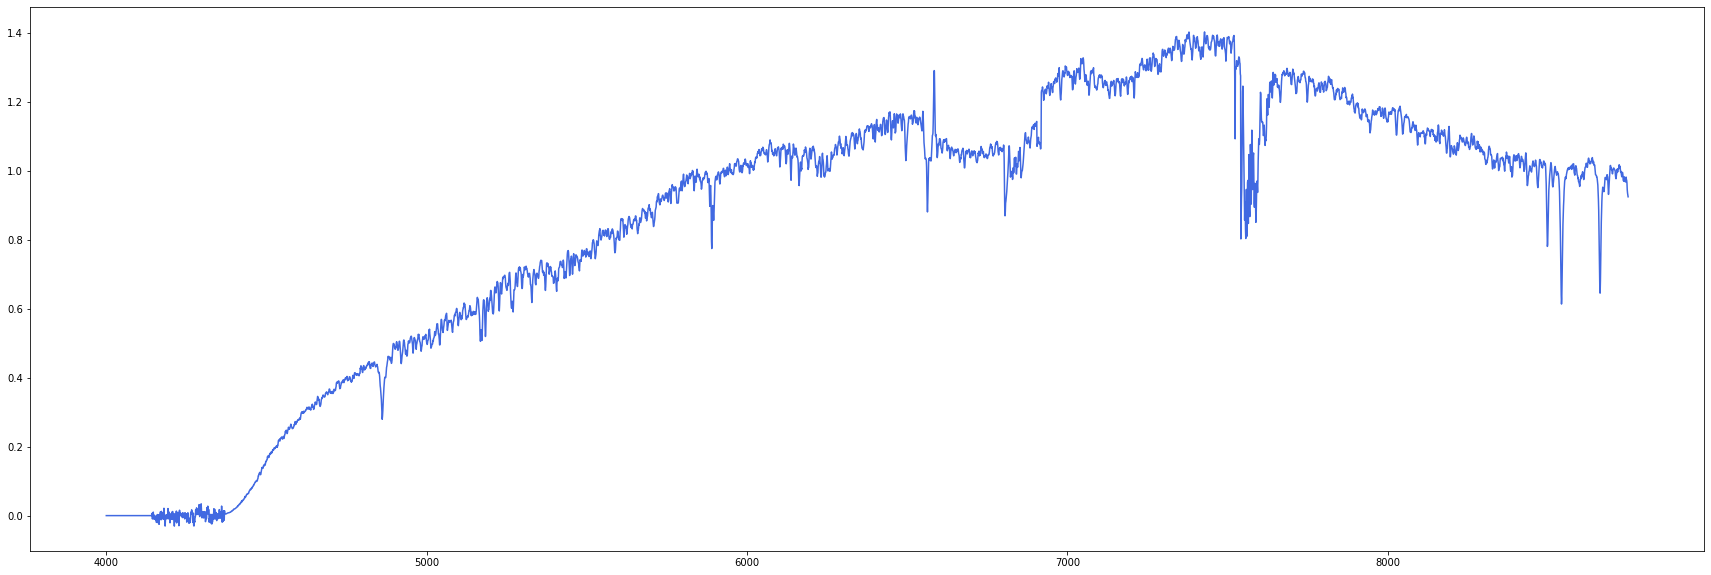

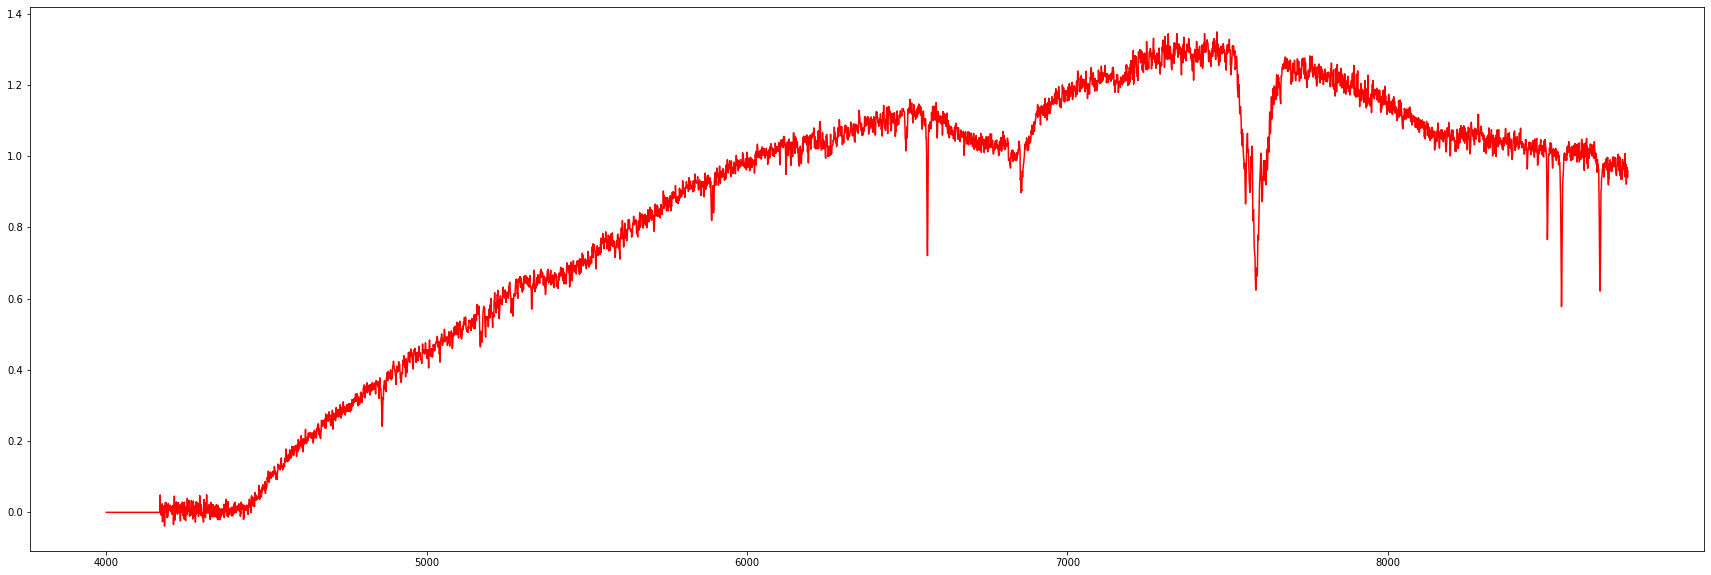

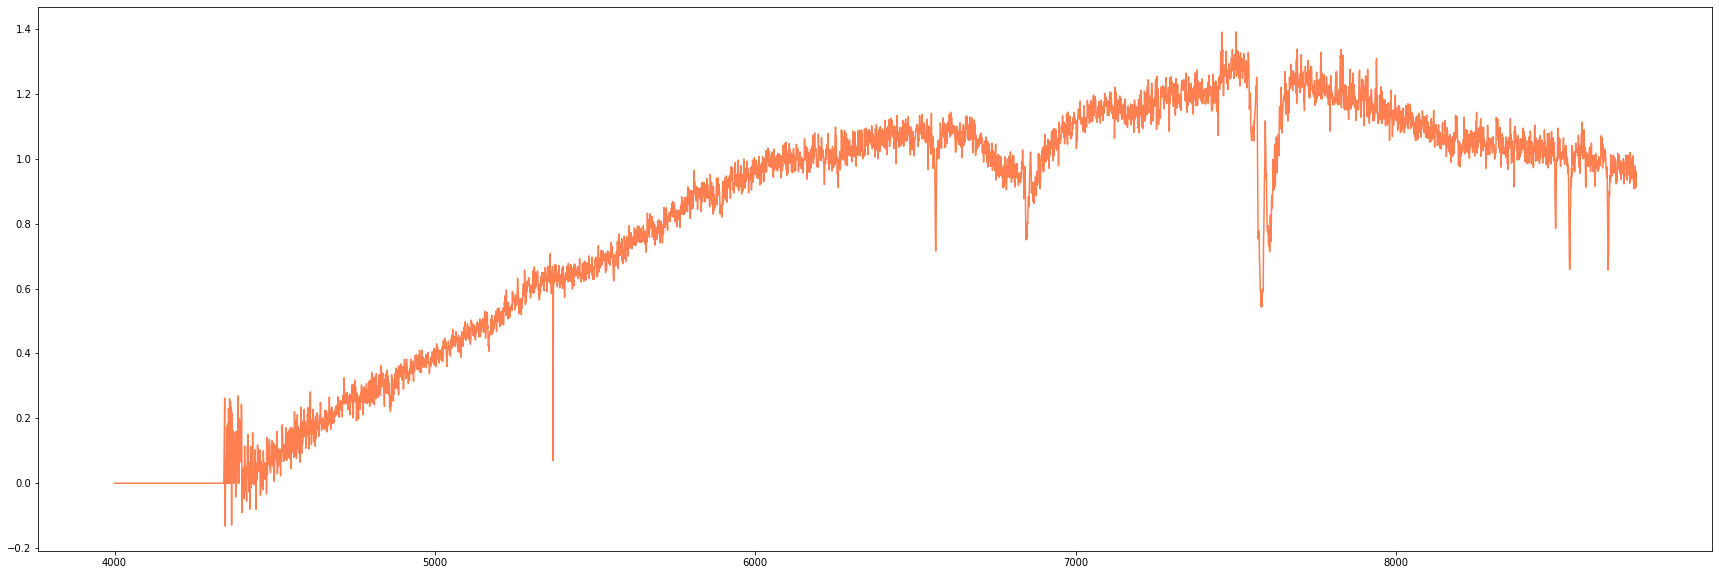

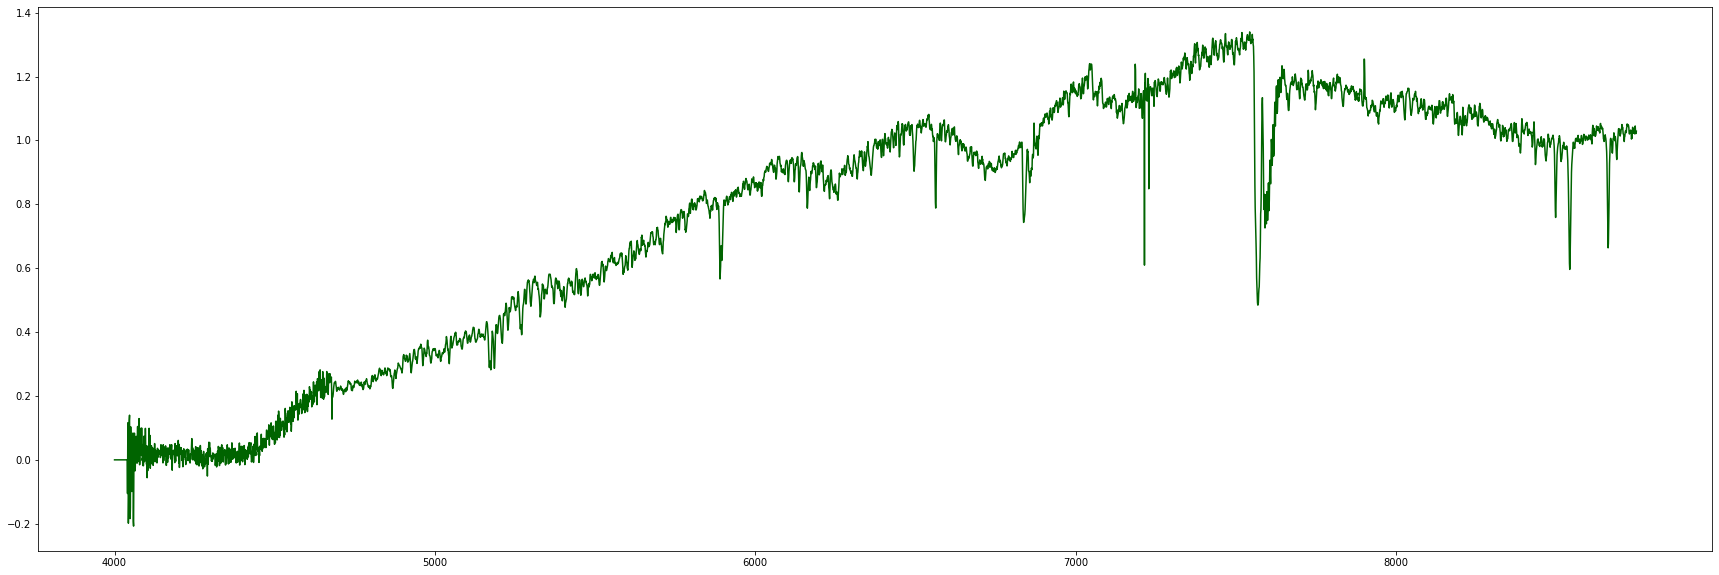

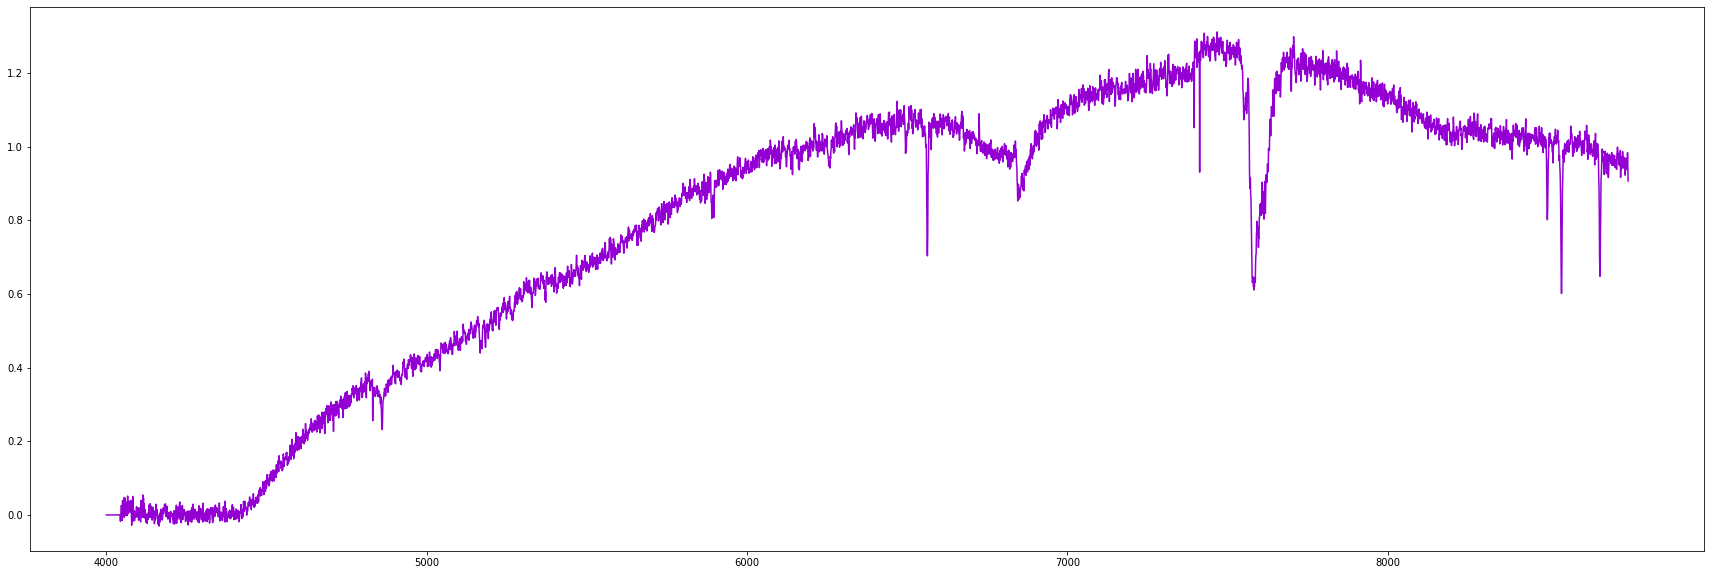

In [13]:
plt.figure(figsize = (30,10))
plt.plot(correct,coadd_spectraDENUC, color = 'royalblue')
plt.show()
#When I graph this, the spectra line is in between 0.8 to 1. Everything else is almost 1. Honestly, so confused...

plt.figure(figsize = (30,10))
plt.plot(correct, coadd_spectraDEGC, color = 'r')
plt.show()

plt.figure(figsize = (30,10))
plt.plot(correct, coadd_spectraUDGGC, color = 'coral')
plt.show()

plt.figure(figsize = (30,10))
plt.plot(correct, coadd_spectraM87, color = 'darkgreen')
plt.show()

plt.figure(figsize = (30,10))
plt.plot(correct, coadd_spectraIGC, color = 'darkviolet')
plt.show()

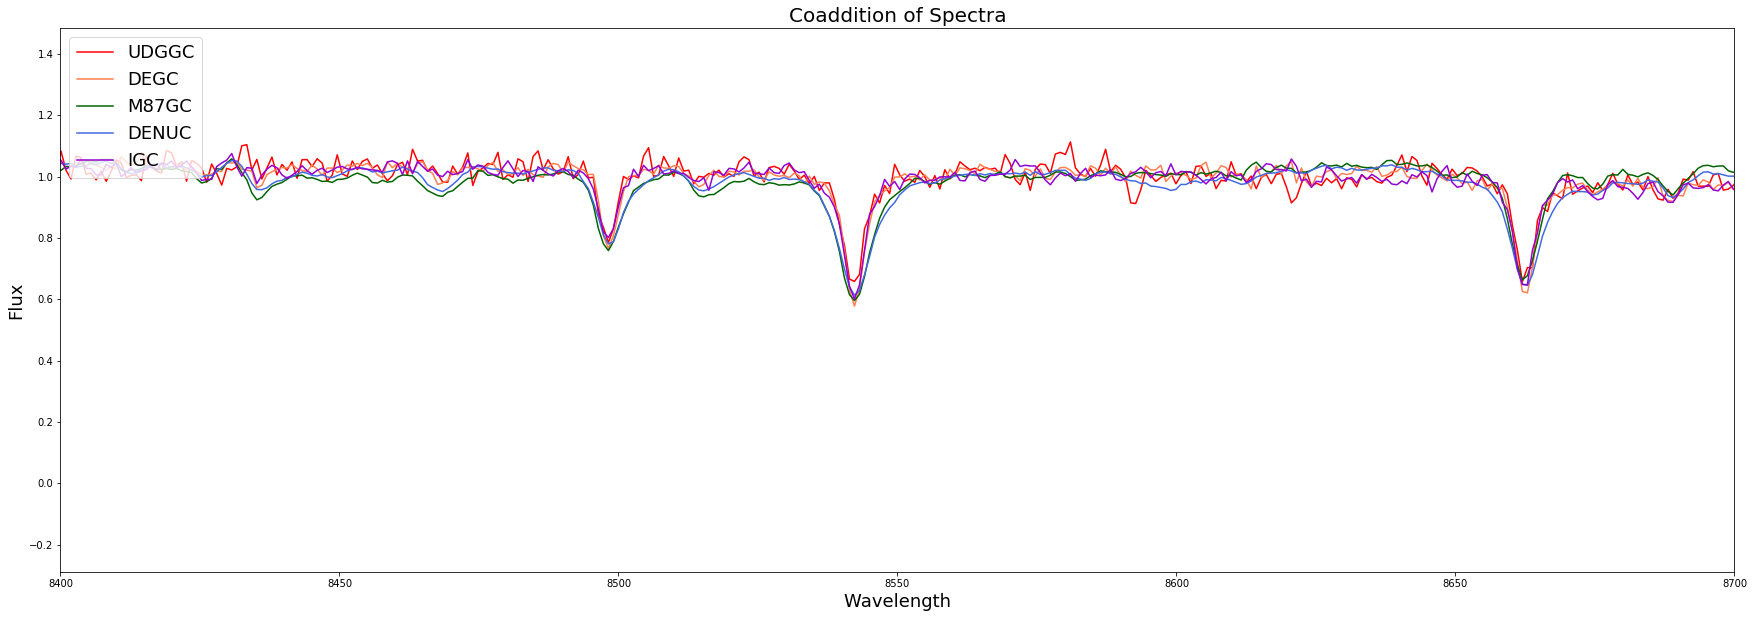

In [14]:
def plot(flux1, flux2, flux3, flux4, flux5, title, xlim):
    plt.figure(figsize = (30,10))
    plt.xlabel('Wavelength', fontsize=18)
    plt.ylabel('Flux', fontsize=18)
    plt.title(title, fontsize = 20)
    if (xlim):
        plt.xlim((8400,8700))
    plt.plot(correct, flux1, label = 'UDGGC', color = 'r')
    plt.plot(correct, flux2, label = 'DEGC', color = 'coral')
    plt.plot(correct, flux3, label = 'M87GC', color = 'darkgreen')
    plt.plot(correct,flux4, label = 'DENUC', color = 'royalblue')
    plt.plot(correct, flux5, label = 'IGC', color = 'darkviolet')
    plt.legend(loc = 'upper left', prop={'size':18})
    
plot(coadd_spectraUDGGC, coadd_spectraDEGC, coadd_spectraM87, coadd_spectraDENUC, coadd_spectraIGC, 'Coaddition of Spectra', xlim = True)

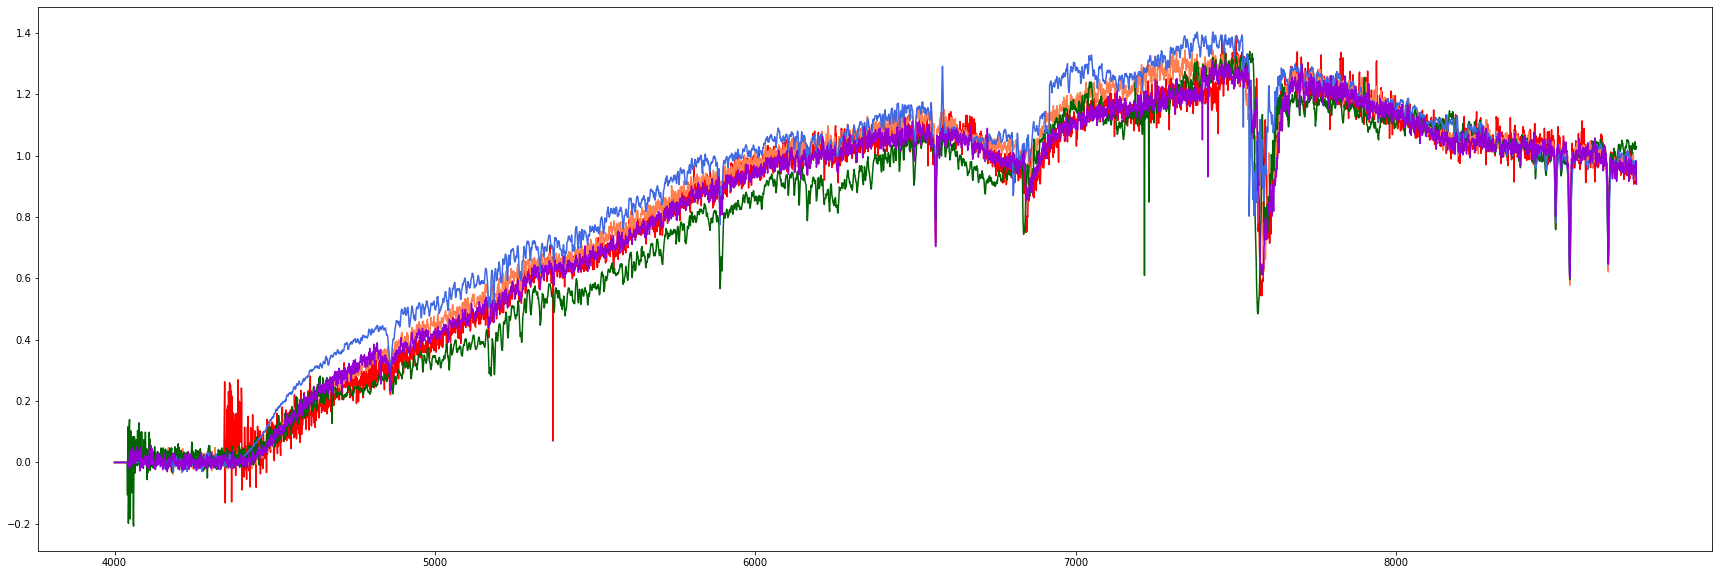

In [15]:
plt.figure(figsize = (30,10))
plt.plot(correct,coadd_spectraUDGGC, color = 'r')
plt.plot(correct,coadd_spectraDEGC, color = 'coral')
plt.plot(correct,coadd_spectraM87, color = 'darkgreen')
plt.plot(correct,coadd_spectraDENUC, color = 'royalblue')
plt.plot(correct,coadd_spectraIGC, color = 'darkviolet')